In [1]:
import os
import sys

In [2]:
sys.path.append('..')

In [3]:
from helpers import *

In [4]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
tf_gpus = [x for x in device_lib.list_local_devices() if x.device_type == 'GPU']


In [5]:
print(tf.__version__)
print(tf_gpus)

1.12.0
[name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6703746908
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5271399449210121436
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [6]:
from scipy.stats import pearsonr

In [7]:
df = msframe('AAPL', 'MSFT', _filter=lambda x: 'adj_close' in x)

In [8]:
pdf = df.pct_change().dropna()

In [9]:
pdf.head()

,AAPL_adj_close,MSFT_adj_close
1998-01-03,-0.007577,-0.001904
1998-01-04,-0.007635,-0.001908
1998-01-05,-0.007694,-0.001911
1998-01-06,0.192701,0.005745
1998-01-07,-0.075992,-0.011967


In [10]:
w_size = 30
window_df = pd.concat([left_windows(pdf[c],w_size) for c in pdf.columns], axis=1)

In [11]:
window_df.shape

(7753, 60)

In [12]:
y = pdf.AAPL_adj_close.loc[window_df.index]

In [50]:
cutoff = datetime.datetime(2012,1,1)

In [51]:
train_x, train_y = window_df[:cutoff], y[:cutoff]
test_x, test_y = window_df[cutoff:], y[cutoff:]

In [52]:
# https://en.wikipedia.org/wiki/Activation_function
model = keras.Sequential([
    keras.layers.Dense(60, activation=tf.nn.softmax),
    keras.layers.Dense(120, activation=tf.nn.softmax),
    keras.layers.Dense(1,activation="linear")
])

In [53]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='mean_squared_error',
              metrics=['accuracy'])

In [54]:
model.fit(train_x.values,train_y.values,epochs=5)

Epoch 1/5
5082/5082 [==============================] - 0s 96us/step - loss: 5.7485e-04 - acc: 0.0104
Epoch 2/5
5082/5082 [==============================] - 0s 60us/step - loss: 5.7132e-04 - acc: 0.0104
Epoch 3/5
5082/5082 [==============================] - 0s 61us/step - loss: 5.7626e-04 - acc: 0.0104
Epoch 4/5
5082/5082 [==============================] - 0s 61us/step - loss: 5.7595e-04 - acc: 0.0104
Epoch 5/5
5082/5082 [==============================] - 0s 60us/step - loss: 5.7384e-04 - acc: 0.0104


In [55]:
test_loss, test_acc = model.evaluate(test_x.values, test_y.values)
test_loss, test_acc

2672/2672 [==============================] - 0s 58us/step


(0.00015640366852282084, 0.0018712574850299401)

<br></br>
## Plot test data

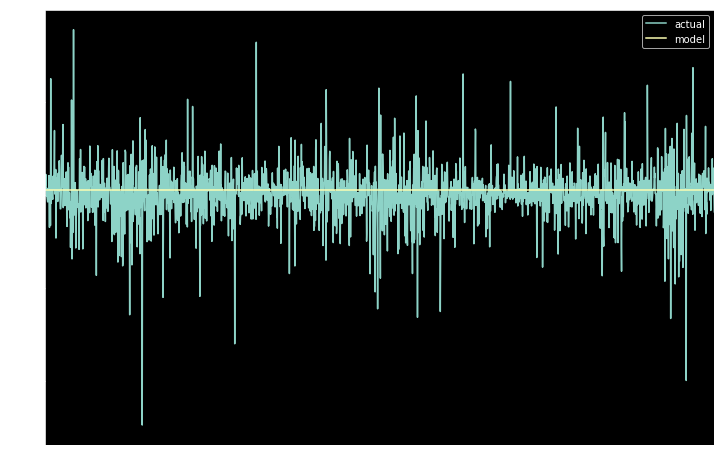

In [56]:
test_yh = np.squeeze(model.predict(test_x))
test_yh = pd.Series(test_yh, index=test_y.index)
compare = pd.concat([test_y.rename('actual'),test_yh.rename('model')],axis=1)
compare.plot(figsize=(12,8))

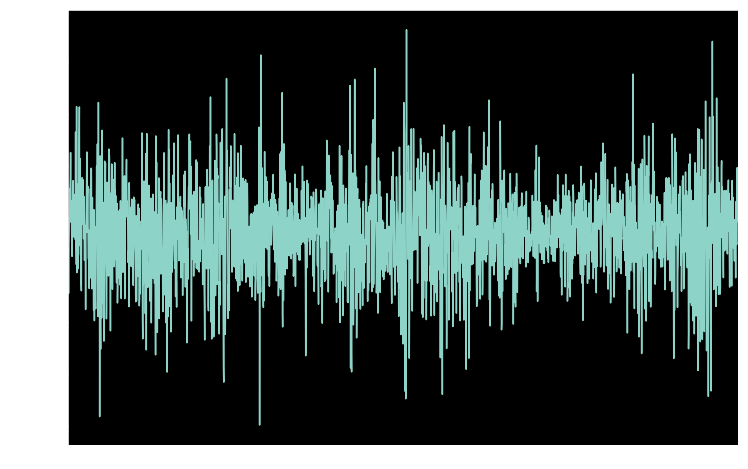

In [57]:
test_yh.plot(figsize=(12,8))

In [58]:
print("Correlation: {}".format(pearsonr(test_y, test_yh)))

Correlation: (0.0005683075872845788, 0.9765751879932263)


<br></br>
### Plot train data

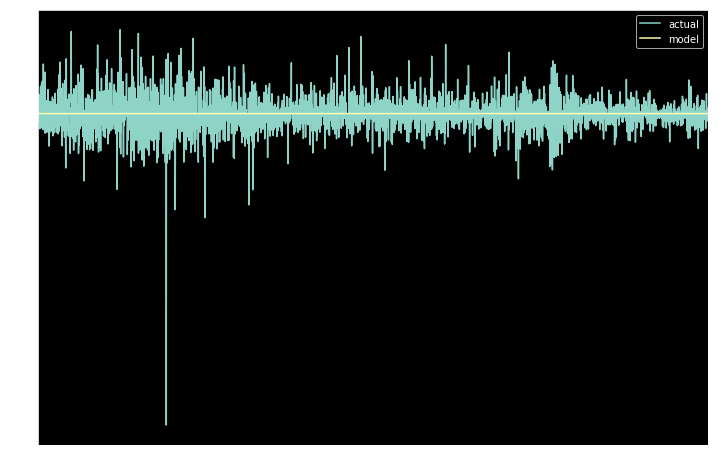

In [59]:
train_yh = np.squeeze(model.predict(train_x))
train_yh = pd.Series(train_yh, index=train_y.index)
compare = pd.concat([train_y.rename('actual'),train_yh.rename('model')],axis=1)
compare.plot(figsize=(12,8))

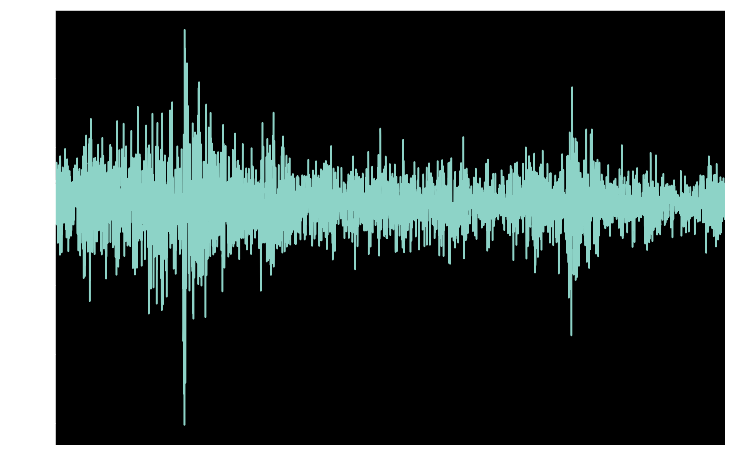

In [60]:
train_yh.plot(figsize=(12,8))